# Chapter 2
## Multi-armed Bandits

### 2.2 Action-value Methods

#### Exercise 2.1
In $\epsilon$-greedy action selection, for the case of two actions and $\epsilon = 0.5$, what is
the probability that the greedy action is selected?

- ***0.75***

### 2.3 The 10-armed Testbed

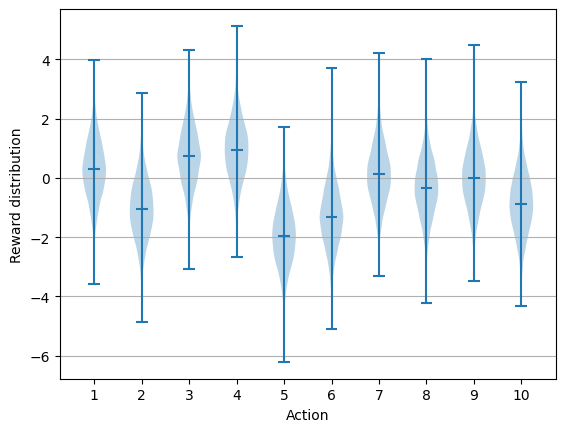

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt

from bandit import run_episode
from agents import EpsilonGreedyAgent


k = 10
seed = 42
num_envs = 2000

vector_kwargs = dict(k=k)
env = gym.make_vec("ArmedBandit-v0", num_envs, "custom", vector_kwargs)
env.reset(seed=seed)
env.render()

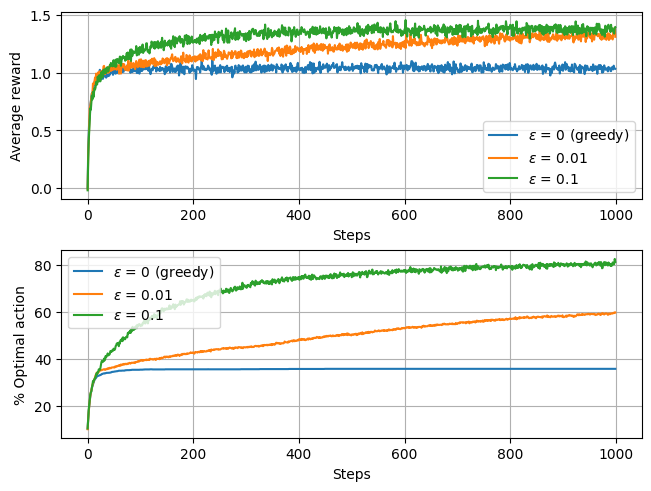

In [2]:
agents = {
    "$\epsilon$ = 0 (greedy)": EpsilonGreedyAgent(k, 0.0, num_envs),
    "$\epsilon$ = 0.01": EpsilonGreedyAgent(k, 0.01, num_envs),
    "$\epsilon$ = 0.1": EpsilonGreedyAgent(k, 0.1, num_envs)
}

data = {"avg_reward": {}, "optimal_action": {}}
for i, (key, agent) in enumerate(agents.items()):
    rewards, optimals = run_episode(env, agent, seed + i)
    data["avg_reward"][key] = rewards.mean(axis=1)
    data["optimal_action"][key] = 100 * optimals.mean(axis=1)


plt.figure(layout="constrained")

plt.subplot(211)
for key in agents.keys():
    plt.plot(key, data=data["avg_reward"])
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.legend()
plt.grid(True)

plt.subplot(212)
for key in agents.keys():
    plt.plot(key, data=data["optimal_action"])
plt.xlabel("Steps")
plt.ylabel("% Optimal action")
plt.legend()
plt.grid(True)

plt.show()

#### Exercise 2.2: Bandit example
Consider a $k$-armed bandit problem with $k = 4$ actions, denoted $1$, $2$, $3$, and $4$. Consider applying to this problem a bandit algorithm using $\epsilon$-greedy action selection, sample-average action-value estimates, and initial estimates of $Q_1(a) = 0$, for all $a$. Suppose the initial sequence of actions and rewards is $A_1 = 1$, $R_1 = −1$, $A_2 = 2$, $R_2 = 1$, $A_3 = 2$, $R_3 = −2, A_4 = 2, R_4 = 2, A_5 = 3, R_5 = 0$. On some of these time steps the $\epsilon$ case may have occurred, causing an action to be selected at random. On which time steps did this definitely occur? On which time steps could this possibly have occurred?

- ***Definitely occured on $t = 4$ and $t = 5$***

- ***Possibly have ocurred on $t = 1$, $t = 2$ and $t = 3$***

#### Exercise 2.3
In the comparison shown in Figure 2.2, which method will perform best in the long run in terms of cumulative reward and probability of selecting the best action? How much better will it be? Express your answer quantitatively.

- ***$\epsilon = 0.01$ will perform best in the long run***
- ***In the long run, the probability of selecting the best action will be $(1 - \epsilon) + \epsilon / k = 1 - (k - 1) \epsilon / k$, which indicates that the lower the $\epsilon$, the greater the probability***
- ***% Optimal action: $99.1\%$***